# Image processing
1. Image are matricies, and all operations are matrix operations

## Color Transformations
### 1. Invert color: transform any color to its complimentary color
$$img(x,y) = 255- img(x,y)$$

In [9]:
import cv2
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
def trans2show(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.imread("lena.jpg")



In [16]:
def invert(img):
    #map invert function to img
    #convert map object to list then to np array
    return np.array(list(map(lambda x: 255-x, img)))

In [17]:
print(img[:10,0,0])
print(invert(img[:10,0,0]))

[58 58 59 60 61 63 62 62 63 62]
[197 197 196 195 194 192 193 193 192 193]


Text(0.5, 1.0, 'Invert GRAY')

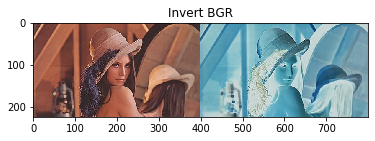

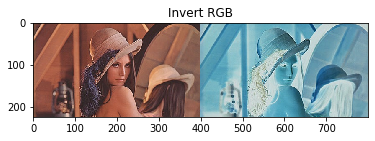

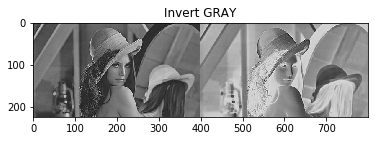

In [22]:
plt.figure()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(trans2show(cv2.hconcat([img,invert(img)])))
plt.title('Invert BGR')
plt.figure()
plt.imshow(cv2.hconcat([trans2show(img),invert(trans2show(img))]))
plt.title('Invert RGB')
plt.figure()
plt.imshow(trans2show(cv2.hconcat([gray,invert(gray)])))
plt.title('Invert GRAY')

### 2. Gamma transformation
This is one simple function that applies curve (as in photoshop) on the image.
$$V_{\mathrm{out}}=C V_{\mathrm{in}}^{\gamma}$$
1. $\gamma<1$: brighten up dark regions
2. $\gamma>1$: darken bright regions
3. Need to normalize after the transformation for display, or else the image will clip
$$C = \dfrac{255}{max(img^\gamma)}$$

<img src="https://www.researchgate.net/profile/Qijie_Zhao/publication/271632132/figure/fig5/AS:703987527454724@1544855114909/Gamma-transformation-of-grey-level.png" alt="Gamma plot" width="500" height="500">

In [68]:
def gamma(img,gamma):
    #convert to exactly the same type as img
    img_g = np.array(list(map(lambda x: x**gamma, img)))
    C = 255/np.max(img_g)
    res = img_g*C
    print(C)
    return res.astype('uint8')

48.3702270868485
0.3301352998405313
49.44423667872545
0.3604476224536234


Text(0.5, 1.0, 'gamma gray')

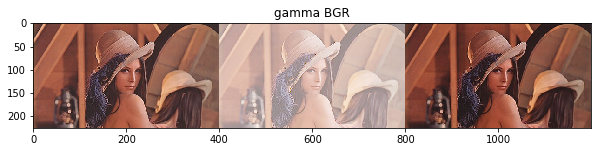

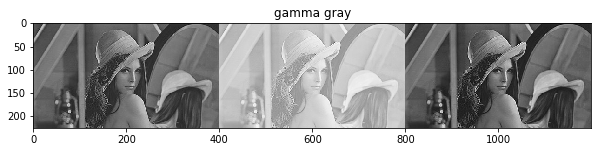

In [78]:
plt.figure(figsize=(10,20))
plt.imshow(trans2show(cv2.hconcat([img,gamma(img,0.3),gamma(img,1.2)])))
plt.title('gamma BGR')
plt.figure(figsize=(10,20))
plt.imshow(trans2show(cv2.hconcat([gray,gamma(gray,0.3),gamma(gray,1.2)])))
plt.title('gamma gray')

### 3. Histogram
A histogram of intensity value counted over all pixels.
1. Create histogram
2. Equilization
<img src="https://miro.medium.com/max/1280/1*Vd5OY8LRaybkFj2NjBbpbA.png" alt="Gamma plot" width="500" height="500">


Text(0, 0.5, 'Count')

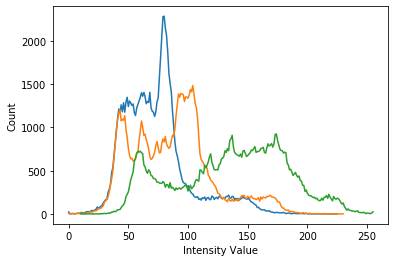

In [164]:
# great histogram
def plot_histogram(img, channel=0):
    if len(img.shape)==3:
        img = img[:,:,channel]
    unique, counts = np.unique(img, return_counts=True)
    plt.plot(unique,counts)
    return dict(zip(unique, counts))
plt.figure()
for i in range(3):
    plot_histogram(img, i)
plt.xlabel('Intensity Value')
plt.ylabel('Count')

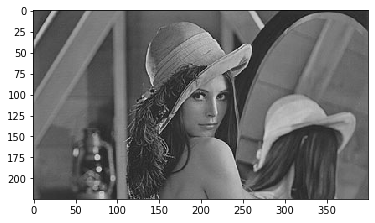

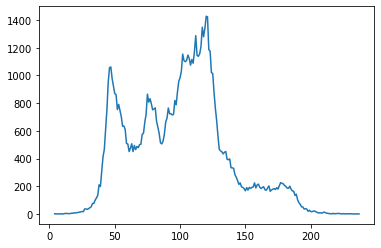

In [168]:
plt.figure()
plt.imshow(trans2show(gray))
plt.figure()
hist = plot_histogram(gray,0)

#### Equilization of  Histogram

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/ca/Histogrammeinebnung.png/600px-Histogrammeinebnung.png" alt="Equilization" width="500" height="500">


In [171]:
def equalization(img, hist, channel):
    size = img.shape[0]*img.shape[1]
    values = np.array(list(hist.values()))
    for i in range(1,len(values)):
        values[i] = values[i-1]+values[i]
    hist = dict(zip(hist.keys(), values*255/size))    
    if len(img.shape)==3:
        img = img[:,:,channel]
    def helper(x):
        return hist[x]
    equalized = np.array([[helper(x) for x in row] for row in img])
    return equalized.astype('uint8')
        

In [172]:
equalized = equalization(gray,hist,0)

Text(0.5, 1.0, 'equalized gray')

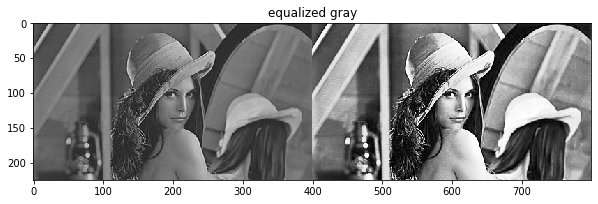

In [173]:
plt.figure(figsize=(10,20))
plt.imshow(trans2show(cv2.hconcat([gray,equalization(gray,hist,0)])))
plt.title('equalized gray')

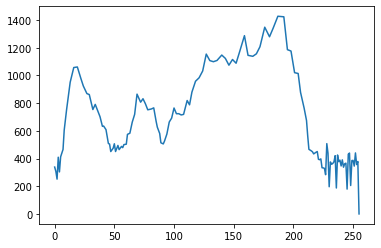

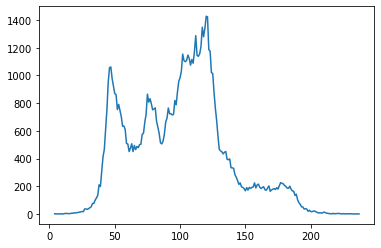

In [174]:
plt.figure()
_ =plot_histogram(equalized)
plt.figure()
_ =plot_histogram(gray)

## Major difference between image process and computer vision
Computer vision: requires decision

# Computer vision
__input__: image (matrix), video(sequence)

__output__:
1. classification: class id
2. detection: location
3. segmentation: detailed mask/ outline
4. description: texts

## Classification, process

0. preprocess: transformations
1. feature extraction (descriptor)
    a. projection (vertical, horizontal)
    b. symmetry
    c. histogram
    d. direct location of pixels
2. classification to class id: (decision function, use model parameters)
    a. from direct equation between image feature and class feature, do not work for large number of images
    b. calculate distance between image feature and class feature, if the distance < some number.
    

__types of decision(error) functions:__

1. distance(Euclidean/L2, L1)
2. min distance
3. inner product
    

__types of features__:

1. Hog (Histogram of oriented gradient): common for human detection
    1. BGR2GRAY: gradient only for grey scale
        1. can involve aforementioned transformations, such as gamma transformation.
    2. calculate gradient for every pixel (magnitude and direction)
        1. use gradient filters (kernel), eg. y gradient, use this kernel to convolute over whole image to get directional gradient for each pixel:
\begin{matrix}
-1 & -1 & -1\\
0 & 0 & 0\\
1 & 1 & 1\\
\end{matrix}
        2. magnitude of gradient: $\sqrt{dx^2+dy^2}$ 
        3. orientation: $\arctan{\dfrac{dy}{dx}}$
        4. output: magnitude matrix, orientation matrix
    3. divide image into small cells (eg 8*8)
    4. obtain gradient histogram for each cell
        1. ```plot(angle, count)```: angle in range, eg. [0,20], [20,40]....
        2. output shape: (1, # ranges)
    5. group every 3*3 cells into a block in a similar fasion to convolution (with block size and stride=1). Concatenate histogram descriptors of these cells: concat([...],[...],[...]) = [.........].
        1. output: (1, 3*3* #ranges)
        2. can add one more layer between cell and block (window)
    6. concat descriptors of every block, normalize to give the final descriptor.
    

2. LBP (local binary pattern)
    1. for a 3*3 cell, select center, for every pixel in the window, ```descriptor=1 if value >=center.value, else=0 ```
        1. for pixels on edges, padding
        2. achieve rotation invariant: let the window rotate, and use min value during the rotation
    2. calculate histogram of each cell, normalize
    3. concat histograms of cells
3. Haar-like: change of image gray scale
    1. use a number of different filters:
        1. vertical edge
\begin{matrix}
-1 & -1 & -1 &-1\\
-1 & -1 & -1&-1\\
1 & 1 & 1&1\\
1 & 1 & 1&1\\
\end{matrix}
        2. horizontal edge
\begin{matrix}
1 & 1 & -1 &-1\\
1 & 1 & -1&-1\\
1 & 1 & -1&-1\\
1 & 1 & -1&-1\\
\end{matrix}       
        3. diagonal edge
        4. Checkerboard filter
        5. and more...


## Homework
1. classification of 10 images
    1. create 10 images of 10 numbers: 0, 1,...9
    2. extract feature
    3. design decision function f(x) for classification
